In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
from nltk import ngrams
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
from helpers import *

In [20]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

### Prepare the Dataset

In [ ]:
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_channels = df_tech_review_channels.drop('Unnamed: 0',axis=1)

# Start of the analysis

Here, we want to see the effect of publishing a video about a specific product during the period of its release on the growth of the channel. We first seperate the channels into 2 categories:
- The ones that have published a video about a product we are analyzing at hand.
- The ones that have NOT published a video about a product we are analyzing at hand.

Then, we compare the trend of the channel's growth over a 1 year period (6 months before and after the release of the product) to see if there is a clear distinction between them.

In [ ]:
# get the copy of the dataframes for the analysis in this section only
df_video = df_tech_review_mt.copy()
df_channel = df_tech_review_channels.copy()

# define the items, to analyze, and their release date
ITEMS = ['iphone x', 'iphone 7', 'galaxy s9']
RELEASE_DATES = {
    'iphone x': pd.to_datetime('2017-11-03'),
    'iphone 7': pd.to_datetime('2016-09-16'),
    'galaxy s9': pd.to_datetime('2018-03-16')}

# get the number of videos about each product for each channel
print('# total videos:',df_video.shape[0])
for item in ITEMS:
    df_video = find_in_name_and_tags(df_video, item, RELEASE_DATES[item])
    product_ch = df_video.groupby('channel_id',as_index=False)[[item]].sum()
    df_channel = pd.merge(df_channel,product_ch,on='channel_id',how='left')
    print(f'# video about {item}: {df_video[item].sum()}')

# print a sample of dataframe
print('# data points:',df_channel.shape[0])
display(df_channel.sample(5))

# total videos: 740018
# video about iphone x: 5735.0
# video about iphone 7: 4383.0
# video about galaxy s9: 3757.0
# data points: 1250


,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,iphone x,iphone 7,galaxy s9
387,2016-01-30,UCa5-N7CN3bwuGT6vl2RmdQg,NextTimeTech,126000,77,124589.0,4.1055,6.0,0.0,0.0,0.0
990,2016-10-14,UCJsc9a4WzqUuPQ27gz57amg,Future 4K,19300,124,560178.0,9.4390,37.0,7.0,0.0,0.0
540,2016-01-09,UCtYJT2feifBiVsxSC1S1Jwg,JSL Review,56200,139,197868.0,5.8385,31.0,4.0,4.0,2.0
1083,2014-07-06,UCRNpHaW_Q2QBhO8DlZubXKg,Tech Ticking,15100,86,675153.0,9.6810,21.0,0.0,0.0,3.0
284,2014-05-05,UCdqs-ItofPRWvLm3mM1dNlg,TechDroider,194000,907,84618.0,4.3550,204.0,4.0,0.0,2.0


Before doing the comparison between 2 groups, we first want to balance these groups on the number of subscribers, frequency of uploading a video, and the ratio of tech review videos, because these features (especially the # subs and tech video ratio) might be a confounder of the growth of the channel.

Now we define the frequency as the average delay in days between publishing to consecutive videos.

Then we divide the group, that has published a video about the product, into 3 categories:
- Those that have published 1-10 videos during the period.
- Those that have published 11-100 videos during the period.
- Those that have published over 100 videos during the period.

In [ ]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define dataframe for observational study
df_obs = pd.merge(df_channel,tech_df_avg,on='channel_id',how='left')

# get the ratio of tech videos
df_obs['tech_videos_ratio'] = df_obs['count_tech_videos'] / df_obs['videos_cc']
df_obs = df_obs[['channel_id','subscribers_cc','avg_delay','tech_videos_ratio'] + ITEMS]

# define 3 categories of channels
df_all = pd.DataFrame()
for item in ITEMS:
    df_bins = df_obs.copy()
    df_bins['treat'] = pd.cut(df_bins[item], [-1, 0, 10, 50, np.inf], labels=['0', '1-10', '11-50', '>50'])
    df_bins = pd.get_dummies(data=df_bins, columns=['treat'])
    # define the product type for each dataframe
    df_bins['product'] = item
    # concatonate the dataframes vertically
    df_all = pd.concat([df_all,df_bins], axis=0)

# print a sample of the preprocessed dataset
print("# data points:",df_all.shape[0])
display(df_all.sample(5)) # number of items * number of tech reviws channels

# data points: 3750


,channel_id,subscribers_cc,avg_delay,tech_videos_ratio,iphone x,iphone 7,galaxy s9,treat_0,treat_1-10,treat_11-50,treat_>50,product
620,UCAmdIitnRhUhfLSYd-VZ2Dw,55500,5.624322,0.079832,5.0,0.0,0.0,1,0,0,0,galaxy s9
456,UCbRlogwNj65Fhyq-wwiJpoQ,102000,38.874606,0.061111,0.0,0.0,0.0,1,0,0,0,iphone 7
321,UCXQpf5LtNl7dbmZlxlFIO_w,188000,48.705093,0.138462,0.0,0.0,0.0,1,0,0,0,iphone x
960,UCNAF78EB4nLLrwUUs7Y0GOw,20600,1.885298,0.065570,0.0,0.0,0.0,1,0,0,0,iphone 7
1016,UCjk0vVUUPGYBajmRCvuEg7A,20400,9.708119,0.366812,13.0,7.0,5.0,0,0,1,0,iphone x


### Balancing the groups

Now, we do a matching between the channels that have no video and each one of the above channels seperately. So that we can see the effect of releasing a different number of videos seperately:

Optimization terminated successfully.
         Current function value: 0.635625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098743
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.572228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306247
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069810
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.580137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.246131
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062399
         Iterations 11
Iphone x
# channel in group 1: 876
# channel in group 2: 230
# channel in group

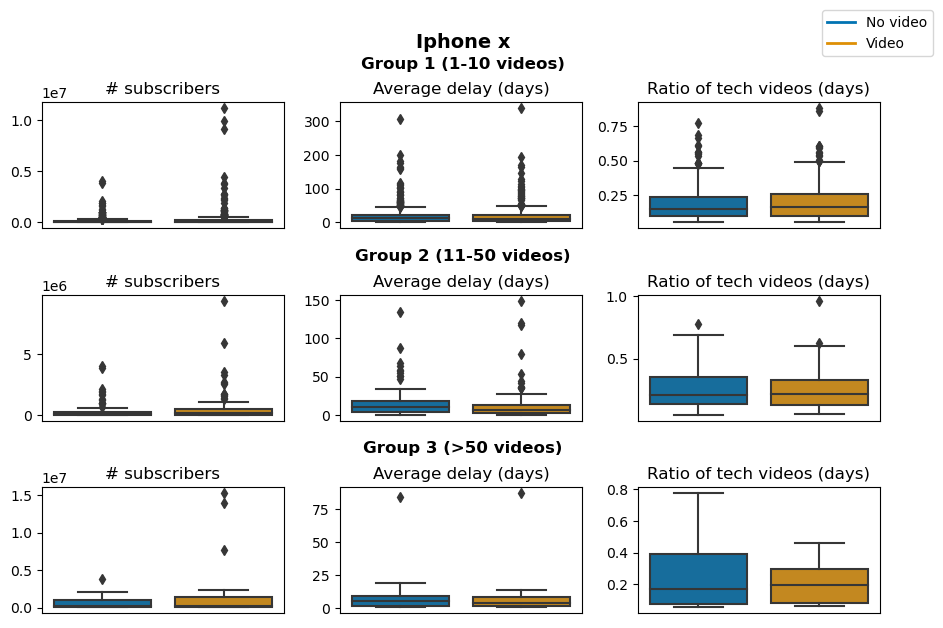

Iphone 7
# channel in group 1: 638
# channel in group 2: 204
# channel in group 3: 28


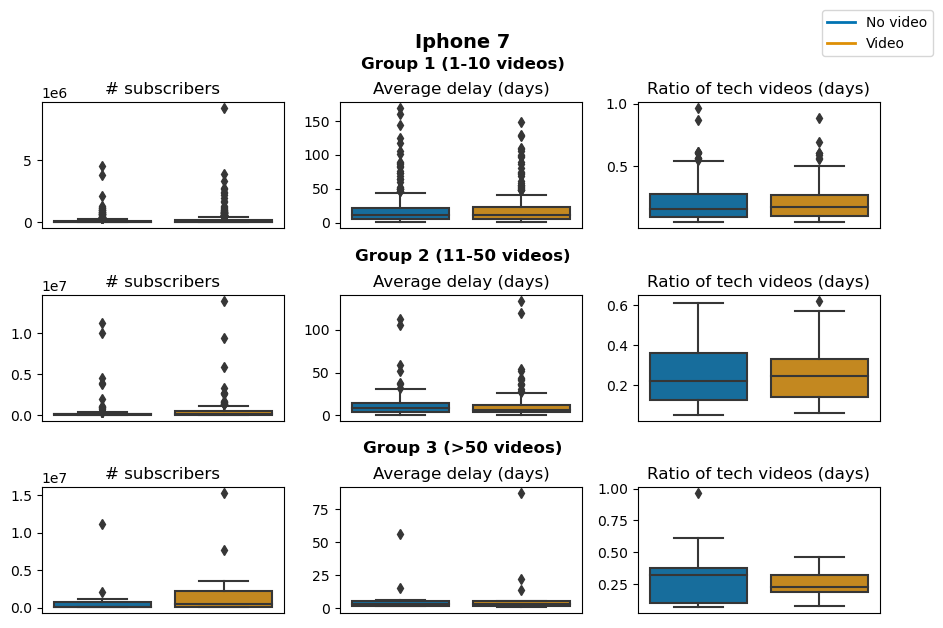

Galaxy s9
# channel in group 1: 724
# channel in group 2: 160
# channel in group 3: 22


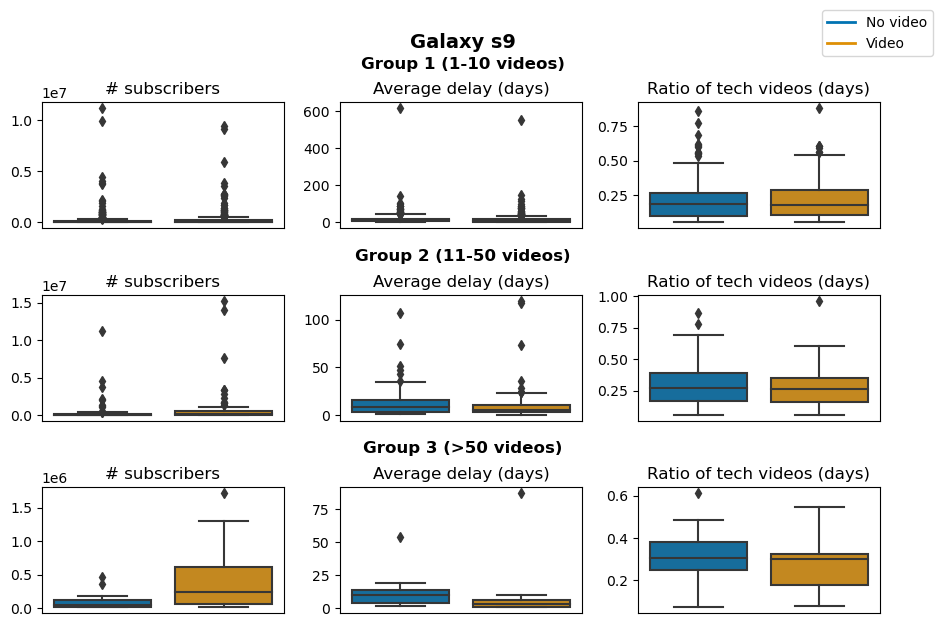

In [ ]:
# define dataframes to store the matched groups
df_1_matched = pd.DataFrame()
df_2_matched = pd.DataFrame()
df_3_matched = pd.DataFrame()

# do the matching on each group for each product
for item in ITEMS:
    # select the current product
    df_obs = df_all[df_all['product'] == item]

    # match the 1st group
    df_1 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_1-10'] == 1)].drop(['treat_0','treat_11-50','treat_>50'],axis=1).rename({'treat_1-10':'treat'},axis=1)
    match_1 = balance_data(df_1,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_1_match = df_1.loc[match_1]
    df_1_matched = pd.concat([df_1_matched, df_1_match], axis=0)

    # match the 2nd group
    df_2 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_11-50'] == 1)].drop(['treat_0','treat_1-10','treat_>50'],axis=1).rename({'treat_11-50':'treat'},axis=1)
    match_2 = balance_data(df_2,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_2_match = df_2.loc[match_2]
    df_2_matched = pd.concat([df_2_matched, df_2_match], axis=0)

    # match the 3rd group
    df_3 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_>50'] == 1)].drop(['treat_0','treat_1-10','treat_11-50'],axis=1).rename({'treat_>50':'treat'},axis=1)
    match_3 = balance_data(df_3,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_3_match = df_3.loc[match_3]
    df_3_matched = pd.concat([df_3_matched, df_3_match], axis=0)

# plot some statistics after the match
for item in ITEMS:
    # select the current product
    df_1_current = df_1_matched[df_1_matched['product'] == item]
    df_2_current = df_2_matched[df_2_matched['product'] == item]
    df_3_current = df_3_matched[df_3_matched['product'] == item]

    # some info about the dataframe
    print(item.capitalize())
    print("# channel in group 1:",df_1_current.shape[0])
    print("# channel in group 2:",df_2_current.shape[0])
    print("# channel in group 3:",df_3_current.shape[0])

    # define the subplots and the colorblind friendly colors
    colors = sns.color_palette("colorblind",2)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,6))

    # # plot group 1
    sns.boxplot(y=df_1_current['subscribers_cc'],x=df_1_current['treat'],ax=axes[0][0],palette=colors)
    sns.boxplot(y=df_1_current['avg_delay'],x=df_1_current['treat'],ax=axes[0][1],palette=colors)
    sns.boxplot(y=df_1_current['tech_videos_ratio'],x=df_1_current['treat'],ax=axes[0][2],palette=colors)

    axes[0][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[0][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.94, 'Group 1 (1-10 videos)', ha='center', weight='bold', fontsize=12)

    # plot group 2
    sns.boxplot(y=df_2_current['subscribers_cc'],x=df_2_current['treat'],ax=axes[1][0],palette=colors)
    sns.boxplot(y=df_2_current['avg_delay'],x=df_2_current['treat'],ax=axes[1][1],palette=colors)
    sns.boxplot(y=df_2_current['tech_videos_ratio'],x=df_2_current['treat'],ax=axes[1][2],palette=colors)

    axes[1][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[1][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[1][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.62, 'Group 2 (11-50 videos)', ha='center', weight='bold', fontsize=12)

    # plot group 3
    sns.boxplot(y=df_3_current['subscribers_cc'],x=df_3_current['treat'],ax=axes[2][0],palette=colors)
    sns.boxplot(y=df_3_current['avg_delay'],x=df_3_current['treat'],ax=axes[2][1],palette=colors)
    sns.boxplot(y=df_3_current['tech_videos_ratio'],x=df_3_current['treat'],ax=axes[2][2],palette=colors)

    axes[2][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[2][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[2][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.3, 'Group 3 (>50 videos)', ha='center', weight='bold', fontsize=12)

    # Create custom legend
    legend_handles = [Line2D([0], [0], color=colors[0], lw=2),
                    Line2D([0], [0], color=colors[1], lw=2)]

    # Use the custom handles in the legend
    fig.legend(handles=legend_handles, labels=['No video', 'Video'], bbox_to_anchor=(1.05, 1.05))
    
    plt.suptitle(item.capitalize(),weight='bold',fontsize=14,x=0.52,y=1)
    plt.tight_layout(h_pad=3)
    plt.show()

From the plots we can see that we manage to balance the groups quite well, except for the Group 3 in some cases, where there are relatively fewer number of channels in each group. This matching should be enough for our analysis, as further matching of groups 3 will result in even fewer data points. We cannot rely too much on the group 3, however group 1 and 2 should give us some good conclusion as they are well balanced. 

### Channel's growth over 1 year period

#### Preparing the time series dataset

In [ ]:
# Load the time series data.
time_series = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")
time_series.datetime = pd.to_datetime(time_series.datetime)
time_series.rename({'channel':'channel_id'},axis=1,inplace=True)
# Get the ratio of new subs and views
time_series['ratio_subs'] = time_series['delta_subs'] / time_series['subs']
time_series['ratio_views'] = time_series['delta_views'] / time_series['views']
# Keep the necessary columns only
time_series_obs = time_series[['channel_id','datetime','ratio_subs','ratio_views','subs']]
time_series_obs['year_month'] = pd.to_datetime(time_series_obs.datetime.dt.strftime('%Y-%m'))

#### Plots of trend

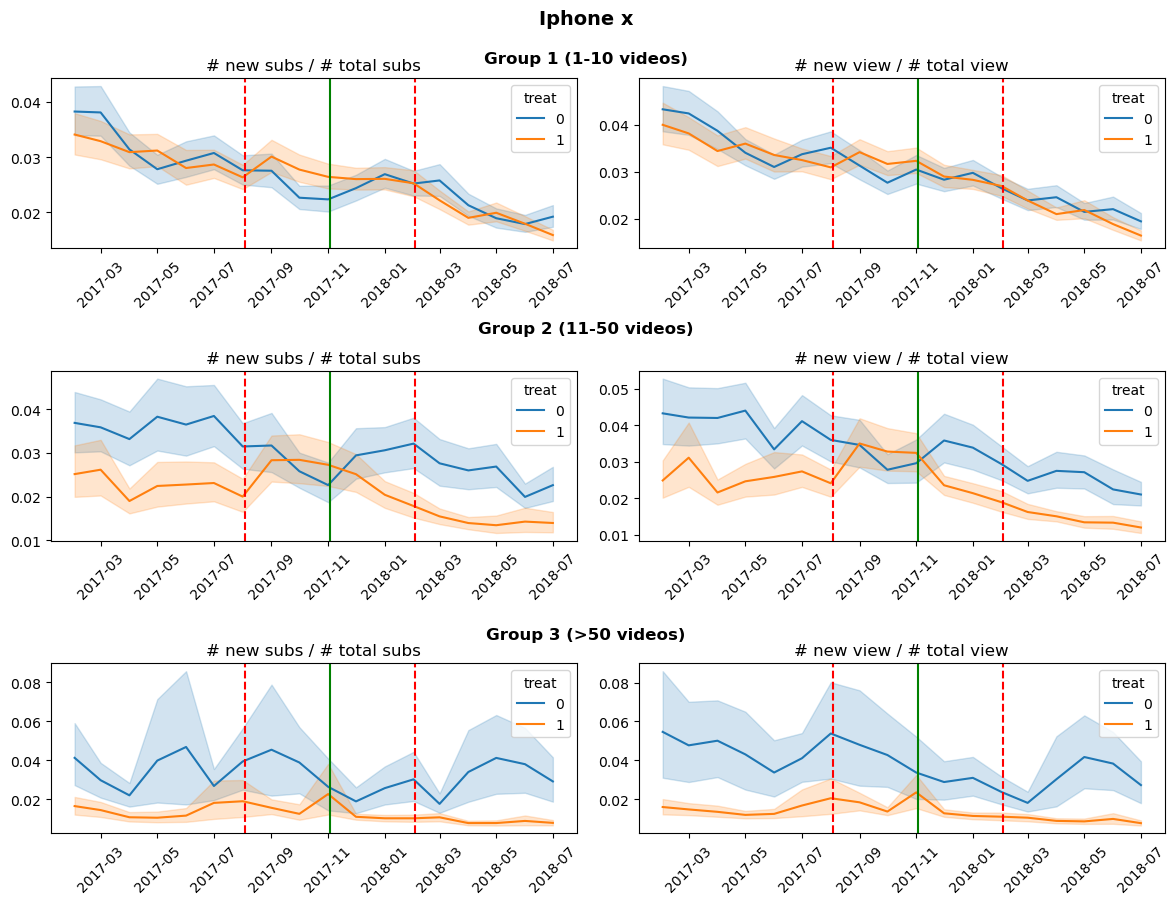

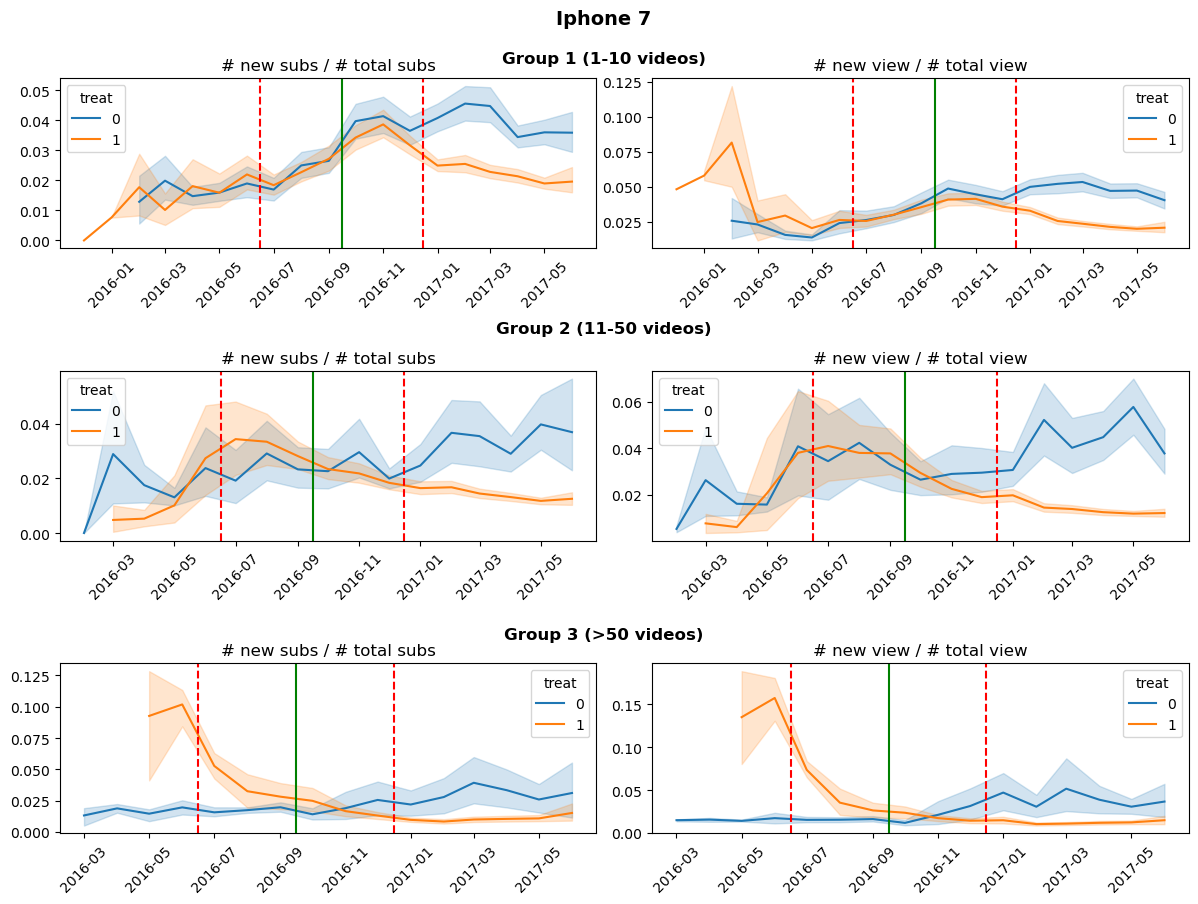

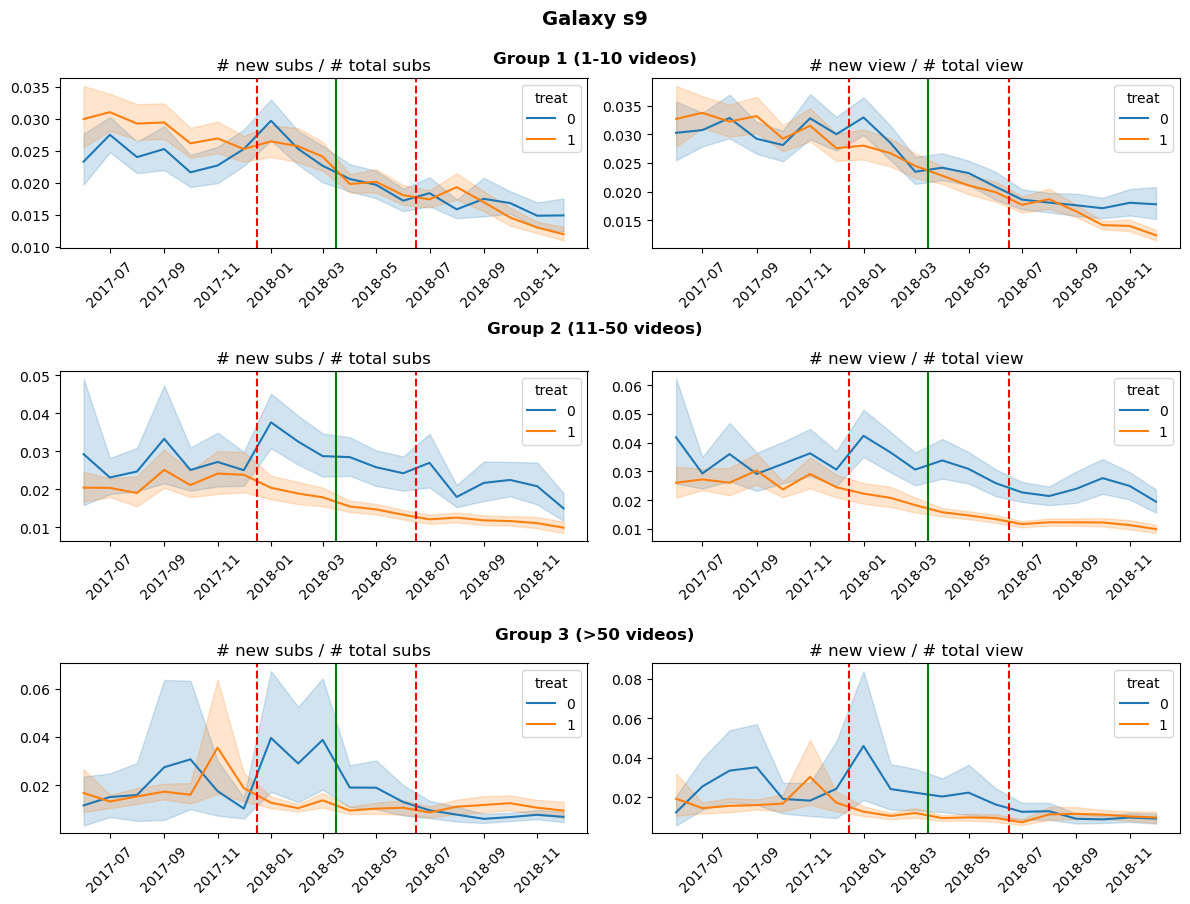

In [ ]:
for item in ITEMS:
    # filtering the time series data: keep the ones with a datetime from 9 months before the release till 9 months after 
    time_series_product = time_series_obs[
            (time_series_obs["datetime"] > RELEASE_DATES[item]-pd.DateOffset(months=9)) & 
            (time_series_obs["datetime"] < RELEASE_DATES[item]+pd.DateOffset(months=9))
        ]

    # get the timeseries data of the 1st group
    df_1_current = df_1_matched[df_1_matched['product'] == item]
    channels_1 = df_1_current.channel_id.unique()
    df_1_time_series = time_series_product[time_series_product.channel_id.isin(channels_1)]
    df_1_time_series = pd.merge(df_1_time_series, df_1_current[['channel_id','treat']], on='channel_id', how='left') 

    # get the timeseries data of the 2nd group
    df_2_current = df_2_matched[df_2_matched['product'] == item]
    channels_2 = df_2_current.channel_id.unique()
    df_2_time_series = time_series_product[time_series_product.channel_id.isin(channels_2)]
    df_2_time_series = pd.merge(df_2_time_series, df_2_current[['channel_id','treat']], on='channel_id', how='left') 

    # get the timeseries data of the 3rd group
    df_3_current = df_3_matched[df_3_matched['product'] == item]
    channels_3 = df_3_current.channel_id.unique()
    df_3_time_series = time_series_product[time_series_product.channel_id.isin(channels_3)]
    df_3_time_series = pd.merge(df_3_time_series, df_3_current[['channel_id','treat']], on='channel_id', how='left') 

    # define the subplots and the colorblind friendly colors
    colors = sns.color_palette("colorblind",2)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9))

    # plot the trends of news subs and views
    sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[0][0])
    sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[0][1])
    sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[1][0])
    sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[1][1])
    sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[2][0])
    sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[2][1])
    
    # set the vertical lines to highlight the period
    for i in range(3):
        for j in range(2):
            axes[i][j].axvline(x=RELEASE_DATES[item], color='green', linestyle='-')
            axes[i][j].axvline(x=RELEASE_DATES[item]-pd.DateOffset(months=3), color='red', linestyle='--')
            axes[i][j].axvline(x=RELEASE_DATES[item]+pd.DateOffset(months=3), color='red', linestyle='--')
            axes[i][j].tick_params(axis='x', rotation=45)

    for i in range(3):
        axes[i][0].set(title='# new subs / # total subs',xlabel=None,ylabel=None)
        axes[i][1].set(title='# new view / # total view',xlabel=None,ylabel=None)

    fig.text(0.5, 0.94, 'Group 1 (1-10 videos)', ha='center', weight='bold', fontsize=12)
    fig.text(0.5, 0.64, 'Group 2 (11-50 videos)', ha='center', weight='bold', fontsize=12)
    fig.text(0.5, 0.3, 'Group 3 (>50 videos)', ha='center', weight='bold', fontsize=12)

    plt.suptitle(item.capitalize(),weight='bold',fontsize=14,x=0.5,y=1)
    plt.xticks(rotation=45)
    plt.tight_layout(h_pad=3)
    plt.show()

As for Iphone X, we see that the channels that have produced a video about it during the 6 month period of its release have seen some increase in the growth of the channel (ratio of new subs/view to the total subs/view), while for the other channels they did not have any dramatic change in their trend. We see this difference in the increase of the trend more clearly especially for the channels that have produced between 1-50 videos, because the number of other channels is too few that we cannot see any increase that clearly (even though we see that it increased on the date of release).

So, let's focus mostly on the channels in Group 1 and 2:

We see an interestin trend in the Group 2 of Iphone 7, namely the trend is increasing for both channels. Let's dig deeper into this. We want to see what the videos were mostly about:

In [ ]:
# get the titles of the 2nd Group of Iphone 7 with no video about Iphone 7
title_sent = df_video[df_video.channel_id.isin(df_2_matched[(df_2_matched['product']=='iphone 7') & (df_2_matched['treat']==0)].channel_id.unique())].title.tolist()

# Tokenize the text into words
text = ' '.join(title_sent)
words = text.split()

# Generate bigrams and count the occurance of each
bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)

# Print the 10 most occured bigrams
sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_bigram_counts[:10])

[(('Samsung', 'Galaxy'), 3994), (('How', 'to'), 1817), (('Unboxing', '&'), 1094), (('Redmi', 'Note'), 1066), (('Hands', 'On'), 1054), (('Xiaomi', 'Mi'), 1018), (('Windows', 'Phone'), 1001), (('Galaxy', 'Note'), 923), (('Top', '5'), 800), (('Sony', 'Xperia'), 799)]


Apparently during this time we had many videos about other tech by Xiaomi and Samsung as well. Indeed, below we list the release dates of other phones by Samsung and Xiaomi, of which the release date overlaps with the perido we are interested in:
| Phone Name                    | Release Date      |
|-------------------------------|-------------------|
| Redmi Note 4G                 | June 15, 2016     |
| Redmi Note 4X                 | August 29, 2016   |
| Redmi Note 3 Pro Prime        | October 17, 2016  |
| Redmi Note 3                  | February 10, 2016 |
| Xiaomi Redmi 3S Prime         | October 17, 2016  |
| Xiaomi Redmi 3S               | June 16, 2016     |
| Xiaomi Redmi 4                | August 24, 2016   |
| Xiaomi Mi 5s                  | September 22, 2016|
| Xiaomi Mi 5s Plus             | September 22, 2016|
| Xiaomi Redmi Note 4 Plus      | August 29, 2016   |
| Samsung Galaxy A5 (2016)      | June 17, 2016     |
| Samsung Galaxy J5 (2016)      | June 22, 2016     |
| Samsung Galaxy J7 (2016)      | June 22, 2016     |
| Samsung Galaxy Grand Prime Plus| July 27, 2016    |
| Samsung Galaxy C5 Pro         | August 20, 2016   |
| Samsung Galaxy J7 Nxt         | October 21, 2016  |
| Samsung Galaxy C7 Pro         | November 8, 2016  |
| Samsung Galaxy A7 (2016)      | November 13, 2016 |


Let us now try other groups as well. For example, 2nd Group of Galaxy s9: 

In [ ]:
# get the titles of the videos of the 2nd Group of galaxy s9 with no video about galaxy s9
title_sent = df_video[df_video.channel_id.isin(df_2_matched[(df_2_matched['product']=='galaxy s9') & (df_2_matched['treat']==0)].channel_id.unique())].title.tolist()

# Tokenize the text into words
text = ' '.join(title_sent)
words = text.split()

# Generate bigrams and count the occurance of each
bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)

# Print the 10 most occured bigrams
sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_bigram_counts[:10])

[(('Samsung', 'Galaxy'), 2382), (('How', 'to'), 1428), (('Top', '5'), 843), (('Unboxing', '&'), 680), (('Redmi', 'Note'), 625), (('Unboxing', 'and'), 543), (('Galaxy', 'Note'), 530), (('Xiaomi', 'Redmi'), 523), (('in', '2019'), 494), (('5', 'Best'), 477)]


Indeed we again see a similar result for this group as well, namely these are the products (other than Galaxy s9) that were released by Samsung and Xiaomi during the period of our analysis:

| Phone Name                  | Release Date      |
|-----------------------------|-------------------|
| Redmi Note 5A               | December 22, 2017 |
| Redmi Note 5A Prime         | January 24, 2018  |
| Redmi Note 5                | February 14, 2018 |
| Redmi Note 5 Pro            | March 15, 2018    |
| Redmi 6 Pro                 | April 20, 2018    |
| Redmi 6A                    | May 22, 2018      |
| Redmi S2                    | May 25, 2018      |
| Xiaomi Mi 8                 | May 29, 2018      |
| Xiaomi Mi 8 Pro             | May 29, 2018      |
| Samsung Galaxy J7 Nxt       | March 29, 2018    |
| Samsung Galaxy A8 (2018)    | April 20, 2018    |
| Samsung Galaxy J6+          | May 30, 2018      |
| Samsung Galaxy J4+          | May 30, 2018      |
| Samsung Galaxy A8+ (2018)   | May 31, 2018      |

From all the observations above, our conclusion can be that when focusing on a particular item, we can have one of the 2 following scenarii :
-either there is a clear gain for the treat channels in term of number of views and subscribers such that the orange curve is above the bleu one inside the window between the 2 red lines whereas it is generally below it outside.
-either there is no gain that appears like previously. In this case, after doing some more investigations, it seems that this could be explained by the fact that the release of the considered item overlaps with other items' releases, which control channels talk about, in such a way that the gains of treat channels still "inferior" to the one of the control ones (the effect of the release of the considered item is "hidden" by the release of other itmes, released at the same time).
Also, we can observe that the curve of number of views and subscribers have usually the same shape (follow the same trend) for a given item, in a given group and for a given type of channel.
Moreover, having a huge number of videos in a channel (greater than 50)  that talk about the release is not a good way to make the channel succeed. The channel do better have to talk about it in a small number of videos.